In [6]:
import sys
import os
import pandas as pd
import numpy as np
from numpy.random import uniform
from numpy.random import randint

import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, average_precision_score
import matplotlib.pyplot as plt


from xgboost import XGBClassifier

# Load your DataFrame with columns 'comments' and 'sentiments'
# Replace 'your_dataframe.csv' with the actual file path
df = pd.read_csv("Data/reviews.csv")
print(df.shape)

# removing null comments
df = df[~df['Comment'].isnull()].reset_index()
print(df.shape)

# setting target
df['Sentiment'] = np.where(
    df['Rating'].isin([1,2]), 0,
    np.where(
        df['Rating'].isin([4,5]), 2,
        np.where(
            df['Rating'].isin([3]), 1, np.nan
        )
    )
)
df['Sentiment'].value_counts(True,dropna=False)

(7863, 5)
(7840, 6)


Sentiment
2.0    0.855740
0.0    0.103061
1.0    0.041199
Name: proportion, dtype: float64

In [7]:
# removing stopwords and punctuation to comments
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
def preprocess_text(text):
    words = [w.lower() for w in text.split() if (w.isalpha() and w.lower() not in stopwords)]
    return ' '.join(words)

df['Comment_v2'] = df['Comment'].apply(preprocess_text)
df['Comment_v2'] 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattmacrides/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0               comfortable take light used personal work
1                               lightweight great machine
2             writing review macbook air two years owning
3       little macbooks ideal students small mature bu...
4       love laptop currently typing sometimes screen ...
                              ...                        
7835    bought sandisk class use htc getting constant ...
7836    used extending capabilities samsung galaxy not...
7837    great card fast comes optional adapter sd clas...
7838                    good amount space stuff want fits
7839    heard bad things micro sd card crapping weeks ...
Name: Comment_v2, Length: 7840, dtype: object

# Modeling with TF-IDF

## Unigram

### Logistic Regression

In [3]:
uni_vectorizer = TfidfVectorizer(strip_accents=None,
                             lowercase=False,
                             preprocessor=None,
                             ngram_range = (1,1))


X_uni = uni_vectorizer.fit_transform(df["Comment_v2"].values.astype('U'))
y = df["Sentiment"]

X_uni_train, X_uni_test, y_train, y_test = train_test_split(X_uni, y, train_size=0.70, random_state = 42)

In [4]:
import joblib
model = joblib.load('/Users/mattmacrides/Personal-Projects-Local/Amazon Sentiment Model (Text Classification)/unigram_xgboost_oversample.joblib')
vectorizer = joblib.load('/Users/mattmacrides/Personal-Projects-Local/Amazon Sentiment Model (Text Classification)/vectorizer.joblib')
string = 'the words'


vectorizer.fit_transform(df["Comment_v2"].values.astype('U'))

# Input string to be predicted
input_text = "Your input text goes here."

# Preprocess the input string using the same vectorizer
input_vector = vectorizer.transform([input_text])
import xgboost as xgb

prediction = model.predict(input_vector)
prediction



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:08:56] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/

array([2], dtype=int32)

0.8673469387755102
0.9120738098094888


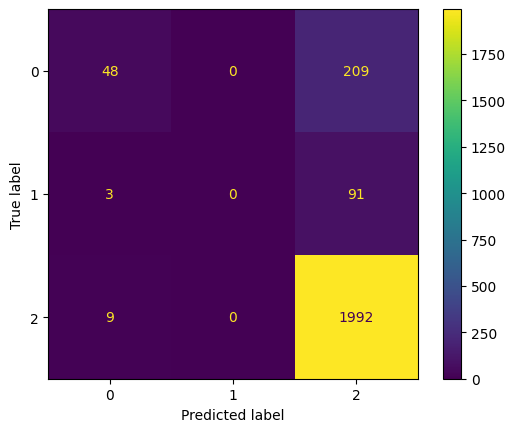

In [5]:
from sklearn.linear_model import LogisticRegression
logreg_uni = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = 42).fit(X_uni_train, y_train)
logreg_uni_preds = logreg_uni.predict(X_uni_test)
print(accuracy_score(logreg_uni_preds,y_test))
print(f1_score(logreg_uni_preds, y_test, average='weighted'))

cm = metrics.confusion_matrix(y_test, logreg_uni_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2])

cm_display.plot()
plt.show()


As you can see these results aren't ideal because almost all records are being labeled as Class 3 (Positive sentiment) no matter what

### XGBoost

#### Tuning

In [7]:
# tuning_path = r'/GroupProject/unigram_xgboost.csv'
# if os.path.exists(tuning_path):
#     pass
# else:
#     print("Now we're tuning hyperparameters for {} iterations ~~>=__=<~~".format(300))
#     header = 'lr,tree,leaf,depth,subsample,colsample,auc_train,auc_test'
#     with open(tuning_path, 'w') as f:
#         f.write(header)
#         f.write('\n')
#     for i in range(300):
#         lr = uniform(low=0.01, high=0.1)
#         tree = randint(low=100, high=1000)
#         leaf = randint(low=3, high=8)
#         depth = randint(low=3, high=6)
#         subsample = uniform(low=0.5, high=1)
#         colsample = uniform(low=0.5, high=1)
#         params = {'learning_rate': lr,
#                 'n_estimators': tree,
#                 'num_leaves': leaf,
#                 'max_depth': depth,
#                 'subsample': subsample,
#                 'colsample_bytree': colsample,
#                 'objective': 'multi:softmax',
#                 'random_state': 42}
#         xgb = XGBClassifier(**params)
#         xgb.fit(X_uni_train, y_train)

#         # train
#         train_preds = xgb.predict(X_uni_train)
#         train_f1score = f1_score(train_preds, y_train, average='weighted')
        
#         # test
#         test_preds = xgb.predict(X_uni_test)
#         test_f1score = f1_score(test_preds, y_test, average='weighted')

#         line = ','.join(str(i) for i in [lr, tree, leaf, depth, subsample, colsample, 
#                                             train_f1score, test_f1score])
#         # print("Line {} is written into result".format(line))
#         with open(tuning_path, 'a') as f:
#             f.write(line)
#             f.write('\n')
#         print("Hyperparameter round {} : {} is finished".format(i, line))
#     print("~~~~Hyperparameter tuning done~~~~")

# xgb_uni_tuning = pd.read_csv(tuning_path)
# xgb_uni_tuning.sort_values('auc_test', ascending=False)

0.8533163265306123
0.9130622264190996


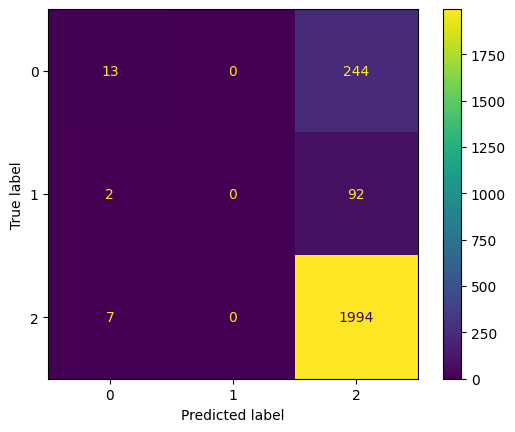

In [6]:
xgb_uni_params = {
    'learning_rate': 0.014648,
    'n_estimators': 103,
    'max_depth': 5,
    'subsample': 0.582055,
    'colsample_bytree': 0.521305,
    'objective': 'multi:softmax',
    'random_state': 42
}

xgb_uni = XGBClassifier(**xgb_uni_params)
xgb_uni.fit(X_uni_train, y_train)
xgb_uni_preds = xgb_uni.predict(X_uni_test)
print(accuracy_score(xgb_uni_preds,y_test))
print(f1_score(xgb_uni_preds, y_test, average='weighted'))

confusion_matrix = metrics.confusion_matrix(y_test, xgb_uni_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])

cm_display.plot()
plt.show()

As you can see it is still tagging positive sentiment for practically all by 19 records

## Oversampling Neutral and Negative Sentiment

Option 1 with TFIDF before SMOTE: using the true IDF weights corresponding to the original text. Disadvantage: not consistent with the modified frequencies caused by SMOTE.

https://datascience.stackexchange.com/questions/116103/do-sampling-before-or-after-tfidf-step

In [7]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_uni_train_over, y_train_over = sm.fit_resample(X_uni_train, y_train)
X_uni_test_over, y_test_over = X_uni_test.copy(), y_test.copy()

In [8]:
print("Pos, Neu, Neg rates in train are {:.2%} {:.2%} {:.2%}".format((y_train_over == 2).sum() / y_train_over.shape[0], (y_train_over == 1).sum() / y_train_over.shape[0], (y_train_over == 0).sum() / y_train_over.shape[0]))
print("Pos, Neu, Neg rates in test are {:.2%} {:.2%} {:.2%}".format((y_test_over == 2).sum() / y_test_over.shape[0], (y_test_over == 1).sum() / y_test_over.shape[0], (y_test_over == 0).sum() / y_test_over.shape[0]))

Pos, Neu, Neg rates in train are 33.33% 33.33% 33.33%
Pos, Neu, Neg rates in test are 85.08% 4.00% 10.93%


0.8312074829931972
0.8214059798095683


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


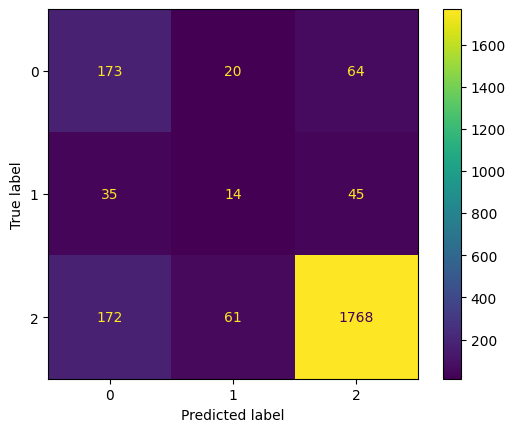

In [9]:
from sklearn.linear_model import LogisticRegression
logreg_uni_over = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42).fit(X_uni_train_over, y_train_over)
logreg_uni_preds_over = logreg_uni_over.predict(X_uni_test_over)
print(accuracy_score(logreg_uni_preds_over,y_test_over))
print(f1_score(logreg_uni_preds_over, y_test_over, average='weighted'))

cm = metrics.confusion_matrix(y_test_over, logreg_uni_preds_over)
cm
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2])

cm_display.plot()
plt.show()


F-Score decreased but the confusiuon matrix is much more balanced due to oversampling

In [12]:
# tuning_path = r'/Users/ethanshen/Documents/UIUC/Fa23/CS410/GroupProject/unigram_oversample_xgboost.csv'
# if os.path.exists(tuning_path):
#     pass
# else:
#     print("Now we're tuning hyperparameters for {} iterations ~~>=__=<~~".format(300))
#     header = 'lr,tree,depth,subsample,colsample,auc_train,auc_test'
#     with open(tuning_path, 'w') as f:
#         f.write(header)
#         f.write('\n')
#     for i in range(300):
#         lr = uniform(low=0.01, high=0.1)
#         tree = randint(low=100, high=1000)
#         depth = randint(low=3, high=6)
#         subsample = uniform(low=0.5, high=1)
#         colsample = uniform(low=0.5, high=1)
#         params = {'learning_rate': lr,
#                 'n_estimators': tree,
#                 'max_depth': depth,
#                 'subsample': subsample,
#                 'colsample_bytree': colsample,
#                 'objective': 'multi:softmax',
#                 'random_state': 42}
#         xgb = XGBClassifier(**params)
#         xgb.fit(X_uni_train_over, y_train_over)

#         # train
#         train_preds = xgb.predict(X_uni_train_over)
#         train_f1score = f1_score(train_preds, y_train_over, average='weighted')
        
#         # test
#         test_preds = xgb.predict(X_uni_test_over)
#         test_f1score = f1_score(test_preds, y_test_over, average='weighted')

#         line = ','.join(str(i) for i in [lr, tree, depth, subsample, colsample, 
#                                             train_f1score, test_f1score])
#         # print("Line {} is written into result".format(line))
#         with open(tuning_path, 'a') as f:
#             f.write(line)
#             f.write('\n')
#         print("Hyperparameter round {} : {} is finished".format(i, line))
#     print("~~~~Hyperparameter tuning done~~~~")

# xgb_uni_tuning = pd.read_csv(tuning_path)
# xgb_uni_tuning.sort_values('auc_test', ascending=False)

0.8622448979591837
0.8754726769524975


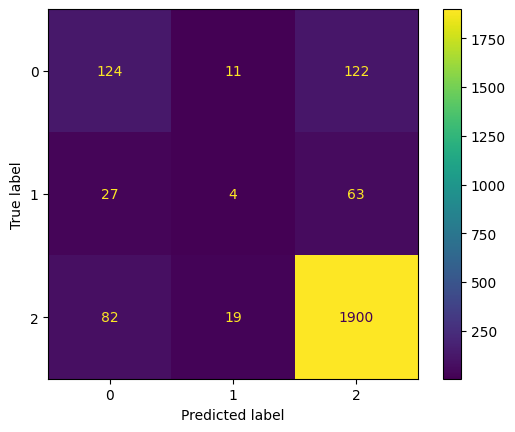

In [10]:
xgb_uni_params = {
    'learning_rate': 0.091607,
    'n_estimators': 843,
    'max_depth': 5,
    'subsample': 0.871868,
    'colsample_bytree': 0.827515,
    'objective': 'multi:softmax',
    'random_state': 42
}

xgb_uni_over = XGBClassifier(**xgb_uni_params)
xgb_uni_over.fit(X_uni_train_over, y_train_over)
xgb_uni_preds_over = xgb_uni_over.predict(X_uni_test_over)
print(accuracy_score(xgb_uni_preds_over,y_test_over))
print(f1_score(xgb_uni_preds_over, y_test_over, average='weighted'))

confusion_matrix = metrics.confusion_matrix(y_test_over, xgb_uni_preds_over)
confusion_matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])

cm_display.plot()
plt.show()

# import joblib
# joblib.dump(xgb_uni_over,r'/Users/ethanshen/Documents/UIUC/Fa23/CS410/GroupProject/unigram_xgboost_oversample.joblib')

Our F1 score went up 5% from hyper parameter tuning

## Bigram

In [11]:
bi_vectorizer = TfidfVectorizer(strip_accents=None,
                             lowercase=False,
                             preprocessor=None,
                             ngram_range = (2,2))


X_bi = bi_vectorizer.fit_transform(df["Comment"].values.astype('U'))
y = df["Sentiment"]

X_bi_train, X_bi_test, y_train, y_test = train_test_split(X_bi, y, train_size=0.70, random_state = 42)


0.8507653061224489
0.9193659545141281


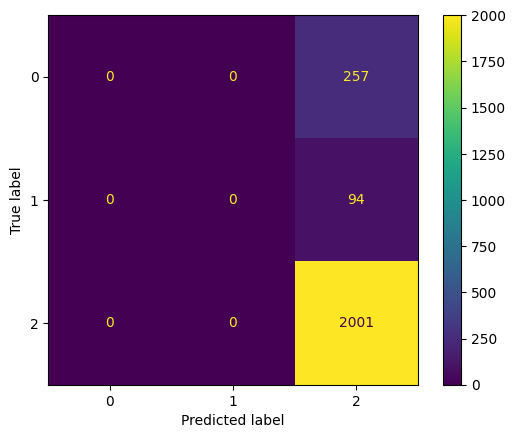

In [12]:
logreg_bi = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_bi_train, y_train)
logreg_bi_preds = logreg_bi.predict(X_bi_test)
logreg_bi_preds_proba = logreg_bi.predict_proba(X_bi_test)

print(accuracy_score(logreg_bi_preds,y_test))
print(f1_score(logreg_bi_preds, y_test, average='weighted'))
cm = metrics.confusion_matrix(y_test, logreg_bi_preds)
cm
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2])

cm_display.plot()
plt.show()

In [13]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state = 42)
X_bi_train_over, y_train_over = sm.fit_resample(X_bi_train, y_train)
X_bi_test_over, y_test_over = X_bi_test.copy(), y_test.copy()
print("Pos, Neu, Neg rates in train are {:.2%} {:.2%} {:.2%}".format((y_train_over == 2).sum() / y_train_over.shape[0], (y_train_over == 1).sum() / y_train_over.shape[0], (y_train_over == 0).sum() / y_train_over.shape[0]))
print("Pos, Neu, Neg rates in test are {:.2%} {:.2%} {:.2%}".format((y_test_over == 2).sum() / y_test_over.shape[0], (y_test_over == 1).sum() / y_test_over.shape[0], (y_test_over == 0).sum() / y_test_over.shape[0]))

Pos, Neu, Neg rates in train are 33.33% 33.33% 33.33%
Pos, Neu, Neg rates in test are 85.08% 4.00% 10.93%


In [14]:
logreg_bi_over = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_bi_train_over, y_train_over)
logreg_bi_preds_over = logreg_bi.predict(X_bi_test_over)

print(accuracy_score(logreg_bi_preds_over, y_test_over))
print(f1_score(logreg_bi_preds_over, y_test_over, average='weighted'))
cm = metrics.confusion_matrix(y_test_over, logreg_bi_preds_over)
cm

0.8507653061224489
0.9193659545141281


array([[   0,    0,  257],
       [   0,    0,   94],
       [   0,    0, 2001]])

It is only marking everything as class 3. So I decided to stay with the unigram oversample model